In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast, os
import matplotlib
import numpy as np
from time import time

matplotlib.rcParams.update({'font.size': 14})

# Read in bounding box coordinates and confidence from each YOLOv5 model

In [2]:
path = '/Users/josephking/Documents/sponsored_projects/MERGEN/data/vehicle_classifier/data_directories'

sm = pd.read_csv(os.path.join(path, 'Bboxes_small.csv'), usecols=['Make', 'Model', 'Category', 'Source Path', 'Bboxes'])
med = pd.read_csv(os.path.join(path, 'Bboxes_medium.csv'), usecols=['Make', 'Model', 'Category', 'Source Path', 'Bboxes'])
lg = pd.read_csv(os.path.join(path, 'Bboxes_large.csv'), usecols=['Make', 'Model', 'Category', 'Source Path', 'Bboxes'])
xl = pd.read_csv('../data/Bboxes.csv', usecols=['Make', 'Model', 'Category', 'Source Path', 'Bboxes'])

sm['Bboxes'] = sm['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
med['Bboxes'] = med['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
lg['Bboxes'] = lg['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
xl['Bboxes'] = xl['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))

#### Ensure datasets same size

In [3]:
assert(len(sm) == len(med) == len(lg) == len(lg))
print(len(sm))

664678


In [4]:
orig_images = len(sm)

In [5]:
sm.head()

,Make,Model,Category,Source Path,Bboxes
0,Acura,CL,Car,Acura/CL/2001/f04ed53e11.jpg,"[10.0, 54.0, 253.0, 128.0, 0.74560546875]"
1,Acura,CL,Car,Acura/CL/2001/6084dddd71.jpg,"[1.0, 47.0, 239.0, 171.0, 0.33984375]"
2,Acura,CL,Car,Acura/CL/2001/723a443ab2.jpg,"[14.0, 47.0, 242.0, 153.0, 0.74560546875]"
3,Acura,CL,Car,Acura/CL/2001/cb6d1e23cb.jpg,"[27.0, 124.0, 1831.0, 901.0, 0.822265625]"
4,Acura,CL,Car,Acura/CL/2001/ede0361fca.jpg,"[42.0, 58.0, 254.0, 136.0, 0.8662109375]"


# Share of images with no car/truck/bus identified by model

Note - no minimum area or minimum confidence threshold has been applied to any datasets

In [6]:
sm = sm.loc[sm.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes
med = med.loc[med.Bboxes.str.len() != 0].reset_index(drop=True)
lg = lg.loc[lg.Bboxes.str.len() != 0].reset_index(drop=True)
xl = xl.loc[xl.Bboxes.str.len() != 0].reset_index(drop=True)

In [7]:
for x in [sm, med, lg, xl]:
    print(len(x))

618653
628858
632260
631973


In [8]:
share_no_vehicle = []
share_no_vehicle.append(1 - (len(sm) / orig_images))
share_no_vehicle.append(1 - (len(med) / orig_images))
share_no_vehicle.append(1 - (len(lg) / orig_images))
share_no_vehicle.append(1 - (len(xl) / orig_images))

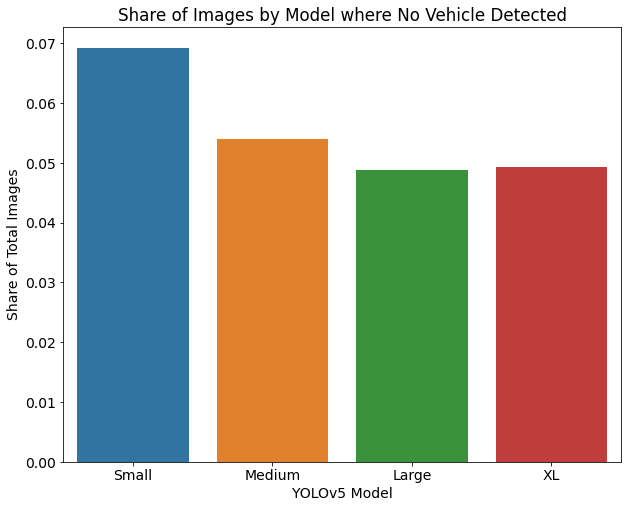

In [9]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
sns.barplot(data=pd.DataFrame(share_no_vehicle).T.rename(columns={0: 'Small', 1: 'Medium', 2: 'Large', 3: 'XL'}))
plt.title('Share of Images by Model where No Vehicle Detected')
plt.xlabel('YOLOv5 Model')
plt.ylabel('Share of Total Images')
plt.savefig('/Users/josephking/Desktop/export/share_no_vehicle_train.png', dpi=200)
plt.show()

# ECDF of model confidence

In [10]:
sm['conf'] = sm['Bboxes'].apply(lambda x: x[-1])
med['conf'] = med['Bboxes'].apply(lambda x: x[-1])
lg['conf'] = lg['Bboxes'].apply(lambda x: x[-1])
xl['conf'] = xl['Bboxes'].apply(lambda x: x[-1])

In [11]:
def calculate_ecdf(series):
    series = series.copy().sort_values()
    cumsum = series.cumsum() / series.sum()
    cumsum.index = series
    return cumsum

In [12]:
ecdf_sm = calculate_ecdf(sm['conf'])
ecdf_med = calculate_ecdf(med['conf'])
ecdf_lg = calculate_ecdf(lg['conf'])
ecdf_xl = calculate_ecdf(xl['conf'])

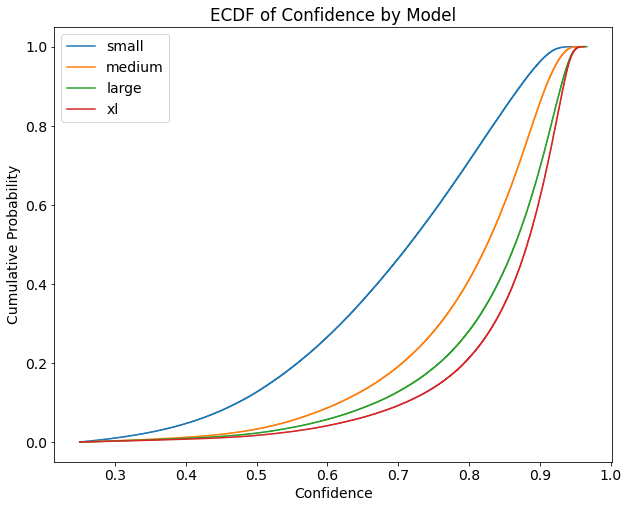

In [13]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
plt.plot(ecdf_sm, label='small')
plt.plot(ecdf_med, label='medium')
plt.plot(ecdf_lg, label='large')
plt.plot(ecdf_xl, label='xl')
plt.legend()
plt.xlabel('Confidence')
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Confidence by Model")
plt.savefig('/Users/josephking/Desktop/export/ECDF_yolo_confidence_train.png', dpi=200)
plt.show()

# Direct comparison of confidence by model

In [14]:
combined = pd.DataFrame(pd.concat([sm['Source Path'], med['Source Path'], lg['Source Path'], xl['Source Path']], 
                                   axis=0).drop_duplicates().reset_index(drop=True), columns=['Source Path'])

In [15]:
combined = combined.merge(sm[['Source Path', 'conf']].rename(columns={'conf': 'sm_conf', 'area': 'sm_area'}), on='Source Path', how='left')
combined = combined.merge(med[['Source Path', 'conf']].rename(columns={'conf': 'med_conf', 'area': 'med_area'}), on='Source Path', how='left')
combined = combined.merge(lg[['Source Path', 'conf']].rename(columns={'conf': 'lg_conf', 'area': 'lg_area'}), on='Source Path', how='left')
combined = combined.merge(xl[['Source Path', 'conf']].rename(columns={'conf': 'xl_conf', 'area': 'xl_area'}), on='Source Path', how='left')
combined = combined.sort_values(by=['Source Path']).reset_index(drop=True)

In [16]:
combined

,Source Path,sm_conf,med_conf,lg_conf,xl_conf
0,Acura/CL/2001/09c41cd670.jpg,0.525879,0.796875,0.823242,0.875000
1,Acura/CL/2001/1575c8d94c.jpg,0.787598,0.871582,0.899414,0.897949
2,Acura/CL/2001/15d2d4bd30.jpg,0.865723,0.894531,0.936035,0.910645
3,Acura/CL/2001/1d81149591.jpg,0.742188,0.881836,0.909668,0.911133
4,Acura/CL/2001/210a1b774a.jpg,0.257324,0.659180,0.602051,0.707520
...,...,...,...,...,...
639539,smart/fortwo/2018/f16fd552c9.jpg,NaN,NaN,0.372314,NaN
639540,smart/fortwo/2018/f2d1a1216f.jpg,0.614746,0.694336,0.860352,0.937500
639541,smart/fortwo/2018/f6b2c3863f.jpg,0.655273,0.846680,0.852539,0.877441
639542,smart/fortwo/2018/f72b3ecf48.jpg,0.276855,0.800293,0.795410,0.853516


In [17]:
combined[['sm_conf', 'med_conf', 'lg_conf', 'xl_conf']].corr()

,sm_conf,med_conf,lg_conf,xl_conf
sm_conf,1.000000,0.589319,0.527105,0.442169
med_conf,0.589319,1.000000,0.706074,0.635833
lg_conf,0.527105,0.706074,1.000000,0.706435
xl_conf,0.442169,0.635833,0.706435,1.000000


## Using small model as reference

In [18]:
conf_diff = pd.DataFrame()
conf_diff['sm_conf'] = round(combined['sm_conf'], 3)
conf_diff['med_sm'] = combined['med_conf'] - combined['sm_conf']
conf_diff['lg_sm'] = combined['lg_conf'] - combined['sm_conf']
conf_diff['xl_sm'] = combined['xl_conf'] - combined['sm_conf']
conf_diff = conf_diff.dropna(axis=0)

conf_diff = conf_diff.groupby('sm_conf').agg({'med_sm': ['mean'], 'lg_sm': ['mean'], 'xl_sm': ['mean']}).reset_index()
conf_diff.columns = ['sm_conf', 'med_sm', 'lg_sm', 'xl_sm']
conf_diff = conf_diff.set_index('sm_conf')

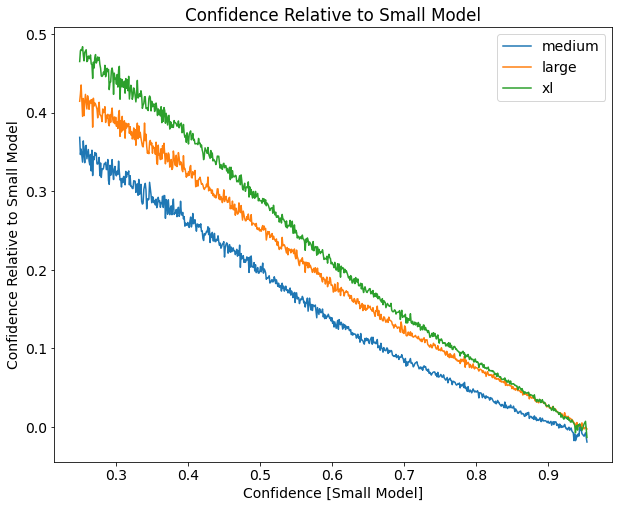

In [19]:
figure(figsize=(10, 8))
plt.plot(conf_diff['med_sm'], label='medium')
plt.plot(conf_diff['lg_sm'], label='large')
plt.plot(conf_diff['xl_sm'], label='xl')
plt.legend()
plt.xlabel('Confidence [Small Model]')
plt.ylabel('Confidence Relative to Small Model')
plt.title('Confidence Relative to Small Model')
plt.show()

## Using XL model as reference against all others

In [20]:
conf_diff_xl = pd.DataFrame()
conf_diff_xl['xl_conf'] = round(combined['xl_conf'], 3)
conf_diff_xl['sm_xl'] = combined['xl_conf'] - combined['sm_conf']
conf_diff_xl['med_xl'] = combined['xl_conf'] - combined['med_conf']
conf_diff_xl['lg_xl'] = combined['xl_conf'] - combined['lg_conf']
conf_diff_xl = conf_diff_xl.dropna(axis=0)

conf_diff_xl = conf_diff_xl.groupby('xl_conf').agg({'sm_xl': ['mean'], 'med_xl': ['mean'], 'lg_xl': ['mean']}).reset_index()
conf_diff_xl.columns = ['xl_conf', 'sm_xl', 'med_xl', 'lg_xl']
conf_diff_xl = conf_diff_xl.set_index('xl_conf')

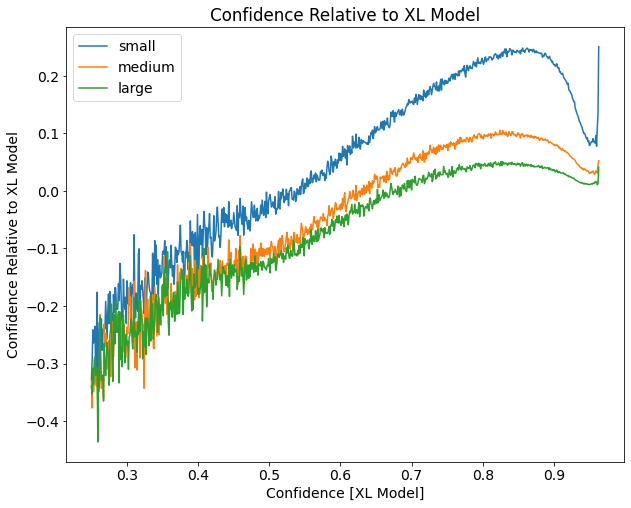

In [21]:
figure(figsize=(10, 8))
plt.plot(conf_diff_xl['sm_xl'], label='small')
plt.plot(conf_diff_xl['med_xl'], label='medium')
plt.plot(conf_diff_xl['lg_xl'], label='large')
plt.legend()
plt.xlabel('Confidence [XL Model]')
plt.ylabel('Confidence Relative to XL Model')
plt.title('Confidence Relative to XL Model')
plt.show()

## Using XL as reference vs medium model

In [22]:
xl_med_diff = combined[['med_conf']].rename(columns={'med_conf': 'conf'})
xl_med_diff['diff'] = (combined['med_conf'] - combined['xl_conf'])
xl_med_diff['conf'] = round(xl_med_diff['conf'], 3)
xl_med_diff = xl_med_diff.sort_values(by=['conf']).reset_index(drop=True)

In [23]:
xl_med_diff_mean = xl_med_diff.groupby('conf')['diff'].mean().reset_index().rename(columns={'diff': 'mean'})
xl_med_diff_std = xl_med_diff.groupby('conf')['diff'].std().reset_index().rename(columns={'diff': 'std'})
xl_med_diff = xl_med_diff_mean.merge(xl_med_diff_std, on='conf', how='outer')
xl_med_diff = xl_med_diff.sort_values(by=['conf'])
xl_med_diff = xl_med_diff.set_index('conf')

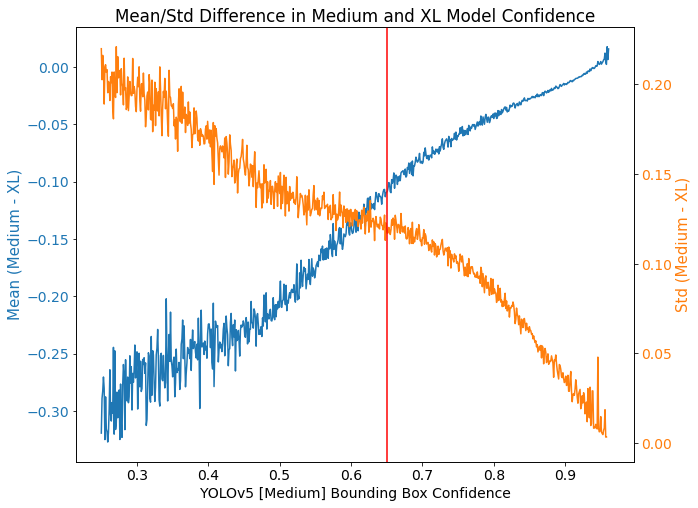

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 8))

color1 = 'tab:blue'
color2 = 'tab:orange'

fig.set_facecolor('white')
ax1.plot(xl_med_diff['mean'], label='mean', color=color1)
ax1.set_ylabel('Mean (Medium - XL)', color=color1, fontsize=15)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()

ax2.plot(xl_med_diff['std'], label='std', color=color2)
ax2.set_ylabel('Std (Medium - XL)', color=color2, fontsize=15)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_xlabel('YOLOv5 [Medium] Bounding Box Confidence')

plt.axvline(x=0.65, color='red')

plt.title('Mean/Std Difference in Medium and XL Model Confidence')
plt.savefig('/Users/josephking/Desktop/export/Medium_XL_Mean_Std_Confidence.png', dpi=200)

plt.show()

# Intersection over Union (IOU)

In [25]:
def bb_intersection_over_union(boxA, boxB):
    # Credit: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

## Compare small, medium, large to XL

In [26]:
bbox = pd.DataFrame(pd.concat([sm['Source Path'], med['Source Path'], lg['Source Path'], xl['Source Path']], 
                                   axis=0).drop_duplicates().reset_index(drop=True), columns=['Source Path'])

bbox = bbox.merge(sm[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'sm', 'conf': 'conf_sm'}), on='Source Path', how='left')
bbox = bbox.merge(med[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'med', 'conf': 'conf_med'}), on='Source Path', how='left')
bbox = bbox.merge(lg[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'lg', 'conf': 'conf_lg'}), on='Source Path', how='left')
bbox = bbox.merge(xl[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'xl', 'conf': 'conf_xl'}), on='Source Path', how='left')
bbox = bbox.dropna(axis=0).reset_index(drop=True)

In [27]:
# Get IoU relative to XL model
bbox['iou_sm_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.sm, x.xl), axis=1)
bbox['iou_med_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.med, x.xl), axis=1)
bbox['iou_lg_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.lg, x.xl), axis=1)

In [28]:
# Global IoU
print(bbox.iou_sm_xl.mean())
print(bbox.iou_med_xl.mean())
print(bbox.iou_lg_xl.mean())

0.9305218786900422
0.9592996841963279
0.9674700445585349


In [29]:
def group_mean(model='sm', round_places=3):
    
    df = bbox[[f"conf_{model}", f"iou_{model}_xl"]].copy()
    df[f"conf_{model}"] = round(df[f"conf_{model}"], round_places)
    return df.groupby(f"conf_{model}")[f"iou_{model}_xl"].mean().reset_index().rename(columns={f"conf_{model}": 'conf'})

In [30]:
foo = group_mean('sm')
for x in ['med', 'lg']:
    temp = group_mean(x)
    foo = foo.merge(temp, on='conf', how='outer')
foo = foo.dropna(axis=0)
foo = foo.sort_values(by=['conf'])
foo = foo.set_index('conf')

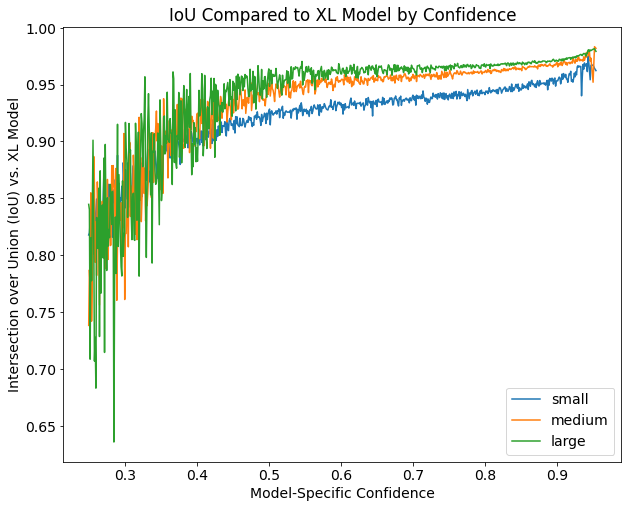

In [31]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
plt.plot(foo['iou_sm_xl'], label='small')
plt.plot(foo['iou_med_xl'], label='medium')
plt.plot(foo['iou_lg_xl'], label='large')
plt.legend()
plt.xlabel('Model-Specific Confidence')
plt.ylabel('Intersection over Union (IoU) vs. XL Model')
plt.title('IoU Compared to XL Model by Confidence')
plt.savefig('/Users/josephking/Desktop/export/IoU_xl_confidence_train.png', dpi=200)
plt.show()

## Deeper dive into medium performance

In [32]:
def group_std(model='sm', round_places=3):
    
    df = bbox[[f"conf_{model}", f"iou_{model}_xl"]].copy()
    df[f"conf_{model}"] = round(df[f"conf_{model}"], round_places)
    return df.groupby(f"conf_{model}")[f"iou_{model}_xl"].std().reset_index().rename(columns={f"conf_{model}": 'conf'})

In [33]:
places = 3

medium_mean = group_mean('med', round_places=places)
medium_std = group_std('med', round_places=places)
medium = medium_mean.merge(medium_std, on='conf', how='outer')
medium.dropna(axis=0, inplace=True)
medium = medium.set_index('conf')

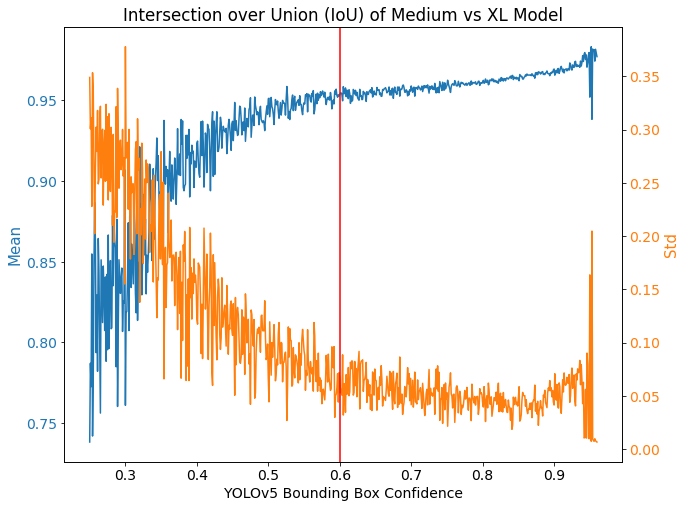

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 8))

color1 = 'tab:blue'
color2 = 'tab:orange'

fig.set_facecolor('white')
ax1.plot(medium['iou_med_xl_x'], label='mean', color=color1)
ax1.set_ylabel('Mean', color=color1, fontsize=15)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()

ax2.plot(medium['iou_med_xl_y'], label='std', color=color2)
ax2.set_ylabel('Std', color=color2, fontsize=15)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_xlabel('YOLOv5 Bounding Box Confidence')

plt.axvline(x=0.6, color='red')

plt.title('Intersection over Union (IoU) of Medium vs XL Model')
plt.savefig('/Users/josephking/Desktop/export/IoU_Medium_XL_Mean_Std.png', dpi=200)

plt.show()

# Examine predictions using Stanford dataset

In [35]:
df = pd.read_csv('/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-03-17h42/logs/predictions.csv')

In [36]:
print(df.head())
print(df.shape)

       Acura CL     Acura ILX  Acura Integra     Acura MDX     Acura NSX  \
0  1.491190e-10  2.229973e-09   6.618325e-08  3.815051e-12  2.457601e-10   
1  8.195306e-07  6.231260e-05   1.287889e-05  1.199257e-07  2.518185e-07   
2  7.014059e-11  7.282454e-12   5.224009e-12  1.752590e-12  1.513660e-11   
3  3.905025e-08  6.816633e-06   2.753966e-08  1.503228e-06  4.076492e-08   
4  4.922883e-14  5.088578e-14   8.747690e-15  2.128516e-15  3.090880e-06   

      Acura RDX      Acura RL     Acura RLX     Acura RSX      Acura TL  ...  \
0  1.496176e-10  6.717188e-09  6.146635e-14  4.742768e-08  1.120251e-09  ...   
1  1.572360e-06  4.229644e-05  4.317398e-06  8.373163e-05  1.030740e-05  ...   
2  3.364636e-12  6.635683e-07  4.351727e-10  2.774323e-12  3.885297e-11  ...   
3  5.381040e-05  2.176227e-05  3.727646e-11  1.055225e-08  3.462195e-05  ...   
4  9.824034e-17  3.724658e-14  8.770909e-16  2.800320e-13  2.158476e-15  ...   

      Volvo V60     Volvo V70     Volvo V90    Volvo XC40    V

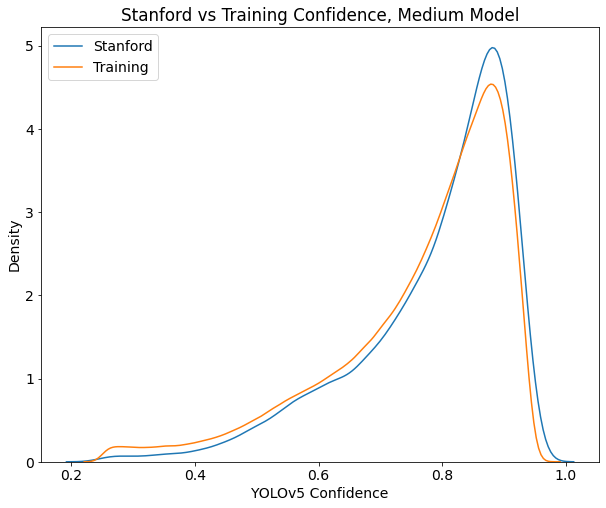

In [37]:
fig = figure(figsize=(10, 8))
fig.set_facecolor('white')
sns.kdeplot(df['conf'], label='Stanford')
sns.kdeplot(med['conf'], label='Training')
plt.xlabel('YOLOv5 Confidence')
plt.title('Stanford vs Training Confidence, Medium Model')
plt.legend()
plt.show()

In [38]:
def argmax_values(dataframe, min_confidence=0.1):
    
    # Enforce confidence
    df = dataframe[dataframe['conf'] >= min_confidence].reset_index(drop=True)
    
    true = df['true_label']
    df.drop(columns=['true_label', 'conf'], inplace=True)
    
    lst = []
    index = df.columns.tolist()
    for i in range(len(df)):
        
        argmax_vals = np.argsort(df.iloc[i].values)[5:] # Get indexes of top argmax values
        names = list(reversed([index[i] for i in argmax_vals]))  # recover string labels from df.columns
        lst.append(names)
    
    pred_classes = pd.DataFrame(lst, columns=['Argmax(' + str(i) + ')' for i in range(len(lst[0]))])
    
    accuracy = pred_classes.apply(lambda x: true == x).mean().cumsum().values
    
    argmax0 = accuracy[0]
    argmax4 = accuracy[4]
    
    return argmax0, argmax4
    

In [39]:
start = time()
lst = []

topval = 95
step = 1

for x in range(25, topval+step, step):
    try:
        argmax0, argmax4 = argmax_values(df, x/100)
        lst.append([x/100, argmax0, argmax4])
    except IndexError:
        continue

print(f"total seconds: {round(time() - start, 2)}")

total seconds: 198.69


In [40]:
foo2 = pd.DataFrame(lst, columns=['conf', 'Argmax(0)', 'Argmax(0:4)'])
foo2 = foo2.set_index('conf')

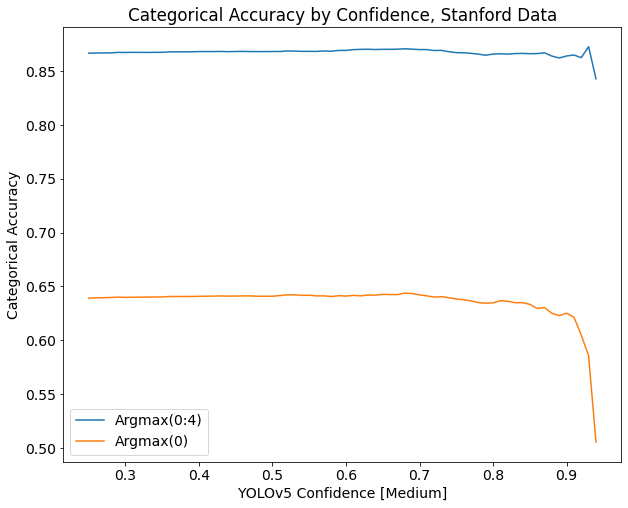

In [41]:
fig = figure(figsize=(10, 8))
fig.set_facecolor('white')
plt.plot(foo2['Argmax(0:4)'].iloc[:-1], label='Argmax(0:4)')
plt.plot(foo2['Argmax(0)'].iloc[:-1], label='Argmax(0)')
plt.ylabel('Categorical Accuracy')
plt.xlabel('YOLOv5 Confidence [Medium]')
plt.legend()
plt.title('Categorical Accuracy by Confidence, Stanford Data')
plt.savefig('/Users/josephking/Desktop/export/Accuracy_Confidence.png', dpi=200)
plt.show()